In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import joblib
import math
import json

In [ ]:
''' PREPROCESSING CAR DATA '''

# Read dataset into df

df = pd.read_csv('cars.csv')
df = df.drop_duplicates()

# Ensure each row fits requirements

for index, row in df.iterrows():
    # Set kilometres on new car to 0 (if nan)
    if type(row['Kilometres']) != str and math.isnan(row['Kilometres']):
        if row['Status'] == 'New':
          df.at[index, 'Kilometres'] = '0 km'

    # Set transmission to either "automatic" or "manual"
    transmission = row['Transmission']
    if type(transmission) != str and math.isnan(transmission):
      continue

    if 'automatic' in transmission.lower():
      df.at[index, 'Transmission'] = 'automatic'
    elif transmission and 'manual' in transmission.lower():
      df.at[index, 'Transmission'] = 'manual'
    else:
      # This will get deleted when dropna() is called
      df.at[index, 'Transmission'] = None

    # General colour
    colour = row['Exterior Colour']
    if type(colour) != str and math.isnan(colour):
      continue

    car_colours = ['Black', 'White', 'Silver', 'Gray', 'Grey', 'Red', 'Blue', 'Green', 'Yellow', 'Orange', 'Brown', 'Beige', 'Gold', 'Maroon', 'Purple', 'Pink']
    for car_colour in car_colours:
      if car_colour in colour:
        # Change to Canadian spelling
        if car_colour == 'Gray':
          df.at[index, 'Exterior Colour'] = 'Grey'
        else:
          df.at[index, 'Exterior Colour'] = car_colour
        break

    # If car colour not recognized then set to None - Will be removed by dropna()
    if not df.at[index, 'Exterior Colour'] in car_colours:
      df.at[index, 'Exterior Colour'] = None

    body_type = row['Body Type']
    if type(body_type) != str and math.isnan(body_type):
      continue

    body_types = [
      'SUV', 'Minivan', 'Coupe', 'Convertible', 'Sedan', 'Truck', 'Hatchback', 'Wagon', 'Cabriolet', 'Compact', 'Van', 'Cab'
    ]
    for cur_body_type in body_types:
      if cur_body_type in body_type.lower():
        df.at[index, 'Body Type'] = cur_body_type
        break

    if not df.at[index, 'Body Type'] in body_types:
      df.at[index, 'Body Type'] = None

# Remove all unnecessary columns

'''
Column Options:
  Province
  Cylinder
  Exterior Colour
  Transmission
  Passengers
  Body Type
  Doors
  City
  Status
  Trim
  Engine
  Drivetrain
  Stock Number
  Interior Colour
  Fuel Type
  City Fuel Economy
  Hwy Fuel Economy
  Transmission
  Price
  Year
  Make
  Model
  Kilometres

Output Column:
  Price
'''

output_column = ['Price']
input_columns = ['Year', 'Make', 'Model', 'Kilometres']
columns_to_keep = output_column + input_columns

df = df[columns_to_keep]
df = df.dropna()

# Convert km and price to int

for index, row in df.iterrows():
    # Convert price to int
    df.at[index, 'Price'] = int(row['Price'].replace(',', ''))

    # Convert km to int
    distance = row['Kilometres'].split()[0]
    distance = distance.replace(',', '')
    df.at[index, 'Kilometres'] = int(distance)

df.to_csv("cars_preprocessed.csv")

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder with the updated parameter
encoder = OneHotEncoder(sparse_output=False)

# Select columns to encode
categorical_cols = ['Make', 'Model']

'''
One-hot encodes specified categorical columns in the DataFrame.

Parameters:
- df (pd.DataFrame): The input DataFrame containing the categorical columns to be encoded.
- categorical_cols (list): A list of column names that are categorical and need encoding.
- oneHotEncoder: An instance of a one-hot encoder (e.g., OneHotEncoder from scikit-learn).
- fit (bool): If True, fits the one-hot encoder to the data before transforming.
              If False, uses the already fitted one-hot encoder to transform the data.

Returns:
- pd.DataFrame: A DataFrame with the specified categorical columns replaced by their one-hot encoded counterparts.
'''
def oneHotEncodeCategoricalCols(df, categorical_cols, oneHotEncoder, fit=False) -> pd.DataFrame:
  # Fit and/or transform the data
  if fit:
    encoded_data = oneHotEncoder.fit_transform(df[categorical_cols])
  else:
    encoded_data = oneHotEncoder.transform(df[categorical_cols])

  # Convert the encoded data to a DataFrame, ensuring the index matches the original DataFrame
  encoded_df = pd.DataFrame(encoded_data, columns=oneHotEncoder.get_feature_names_out(categorical_cols), index=df.index)

  # Drop the original categorical columns before concatenation
  df.drop(columns=categorical_cols, inplace=True)

  # Concatenate with the original DataFrame
  df_encoded = pd.concat([df, encoded_df], axis=1)

  return df_encoded

df_encoded = oneHotEncodeCategoricalCols(df, categorical_cols, encoder, fit=True)
df_encoded

,Price,Year,Kilometres,Make_Ford,Make_acura,Make_alfa romeo,Make_aston martin,Make_audi,Make_bentley,Make_bmw,...,Model_xv crosstrek,Model_xv crosstrek hybrid,Model_yaris,Model_yukon,Model_yukon xl,Model_z,Model_z3 m,Model_z4,Model_z8,Model_zdx
0,39399,2023,13937,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7494,2013,300622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,45785,2020,74851,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,94100,2024,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,88140,2024,33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89671,18991,2020,92021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89672,20888,2021,89149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89674,29888,2020,72974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89676,32448,2024,3407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Save the fitted encoder to a file
joblib.dump(encoder, 'encoder.pkl')

['encoder.pkl']

In [ ]:
from sklearn.preprocessing import StandardScaler

# Identify numerical columns to scale
numerical_cols = ['Kilometres', 'Year']

scaler = StandardScaler()

'''
Scales numerical columns in the DataFrame using the provided scaler and optionally fits the scaler.

Parameters:
- df (pd.DataFrame): The input DataFrame containing the data to be scaled.
- numerical_cols (list): A list of column names that are numerical and need scaling.
- scaler: A scaler instance (e.g., StandardScaler, MinMaxScaler) from scikit-learn to apply scaling.
- fit (bool): If True, fits the scaler to the numerical data before transforming it.
              If False, uses the already fitted scaler to transform the numerical data.

Returns:
- pd.DataFrame: A DataFrame with scaled numerical columns concatenated with the other unaltered columns.
'''
def scaleNumericalCols(df, numerical_cols, scaler, fit=False) -> pd.DataFrame:

  # Separate numerical and other columns
  numerical_data = df[numerical_cols]
  other_data = df.drop(columns=numerical_cols)

  # Apply StandardScaler only to numerical columns
  if fit:
    numerical_scaled = pd.DataFrame(scaler.fit_transform(numerical_data), columns=numerical_cols, index=df.index)
    joblib.dump(scaler, 'scaler_x.pkl')
  else:
    numerical_scaled = pd.DataFrame(scaler.transform(numerical_data), columns=numerical_cols, index=df.index)

  # Concatenate scaled numerical columns with one-hot encoded columns
  df_scaled = pd.concat([numerical_scaled, other_data], axis=1)

  return df_scaled

df_scaled = scaleNumericalCols(df_encoded, numerical_cols, scaler, fit=True)
df_scaled

,Kilometres,Year,Price,Make_Ford,Make_acura,Make_alfa romeo,Make_aston martin,Make_audi,Make_bentley,Make_bmw,...,Model_xv crosstrek,Model_xv crosstrek hybrid,Model_yaris,Model_yukon,Model_yukon xl,Model_z,Model_z3 m,Model_z4,Model_z8,Model_zdx
0,-0.961651,0.723357,39399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.161003,-2.068188,7494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.126796,-0.114106,45785,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.210685,1.002512,94100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.210096,1.002512,88140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89671,0.433599,-0.114106,18991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89672,0.382281,0.165048,20888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89674,0.093256,-0.114106,29888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89676,-1.149807,1.002512,32448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming 'Price' is the output column in the DataFrame
X = df_scaled.drop('Price', axis=1)  # Input features (scaled + one-hot encoded)
y = df['Price']  # Output column (scaled)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)

X_train

array([[ 3.50411831, -0.95157014,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.70268158,  0.72335735,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 3.29798637, -1.5098793 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.38873062,  0.72335735,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.70734528,  0.72335735,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.39621825, -0.39326098,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
# Assume `X_train` is your input feature DataFrame used for training
input_columns = X.columns

# Save input columns to a CSV file
input_columns.to_series().to_csv('input_layer_columns.csv', index=False)

In [ ]:
# Define the ANN model
model = Sequential()

# Input layer and first hidden layer (add more layers as needed)
model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))

# Add more hidden layers if necessary
model.add(Dense(units=32, activation='relu'))

# Output layer (1 unit for regression)
model.add(Dense(units=1, activation='linear'))  # 'linear' activation for regression

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [ ]:
# Convert features to float32
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

# Convert target (output) to float32
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# Scale the target variable (y_train)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

joblib.dump(scaler_y, 'scaler_y.pkl')

# Scale the test target variable for comparison later (optional but helpful)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

In [ ]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

# Train the model
history = model.fit(X_train, y_train_scaled, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.1200 - mean_absolute_error: 0.0874 - val_loss: 0.0172 - val_mean_absolute_error: 0.0701
Epoch 2/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3.5871 - mean_absolute_error: 0.0881 - val_loss: 0.0142 - val_mean_absolute_error: 0.0526
Epoch 3/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6508 - mean_absolute_error: 0.0610 - val_loss: 0.0179 - val_mean_absolute_error: 0.0532
Epoch 4/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.1272 - mean_absolute_error: 0.0624 - val_loss: 0.0782 - val_mean_absolute_error: 0.0766
Epoch 5/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.6835 - mean_absolute_error: 0.0780 - val_loss: 0.0344 - val_mean_absolute_error: 0.0530
Epoch 6/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 1.6115 - mean_absolute_error: 0.0752 - val_loss: 0.0532 - val_mean_absolute_error: 0.0541
Epoch 7/100
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6893 - mean_absol

In [ ]:
# Load the saved model
model.save('car_price_prediction_model.keras')

# Make predictions on the test set
y_pred_scaled = model.predict(X_test)
y_pred_scaled.shape

# Inverse transform the predictions to get them back to the original price scale
y_pred_original = scaler_y.inverse_transform(y_pred_scaled)

# Inverse transform the test set target values to compare them on the original scale
y_test_original = scaler_y.inverse_transform(y_test_scaled)

total = 0
num = 0
# Display some of the predicted and actual values
for pred, actual in zip(y_pred_original, y_test_original):
    diff = abs(actual[0] - pred[0])
    total += diff
    num += 1

    # print(f"Predicted Price: {pred[0]:.2f}, Actual Price: {actual[0]:.2f}")

print("average error is " + str(total/num))

y_test_original.shape

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
average error is 7668.717


(2403, 1)

In [ ]:
import pandas as pd

def predict_price(year, car_make, car_model, kilometres, prediction_model, output_scaler) -> float:
  # Create a DataFrame from the input data
  input_data = pd.DataFrame({
      'Year': [year],
      'Make': [car_make],
      'Model': [car_model],
      'Kilometres': [kilometres]
  })

  # Create the DataFrame for input data
  df = pd.DataFrame(input_data)

  encoded_single_car_df = oneHotEncodeCategoricalCols(df, categorical_cols, encoder)
  scaled_single_car_df = scaleNumericalCols(encoded_single_car_df, numerical_cols, scaler)

  # Find columns in encoded_df that are not in encoded_single_car_df
  missing_columns = [col for col in X.columns if col not in scaled_single_car_df.columns]

  # Add missing columns to data and set all values to zero
  for col in missing_columns:
      scaled_single_car_df[col] = 0

  single_car_numpy_array = scaled_single_car_df.to_numpy()

  # Make a prediction using the trained model
  prediction = prediction_model.predict(single_car_numpy_array)

  # Inverse transform the prediction to get it back to the original price scale
  prediction_original = output_scaler.inverse_transform(prediction)

  return round(prediction_original[0][0], 2)


In [ ]:
prediction = predict_price(2018, 'volkswagen', 'golf gti', 40000, model, scaler_y)
print('Your cars prediction is: ' + str(prediction))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Your cars prediction is: 25933.26


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
[10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000, 140000, 150000, 160000, 170000, 180000, 190000]
[82709.26, 63946.12, 47800.9, 44841.99, 41869.22, 39544.82, 37453.29, 35118.51, 32725.41, 30661.54, 29066.79, 27435.06, 26251.81, 253

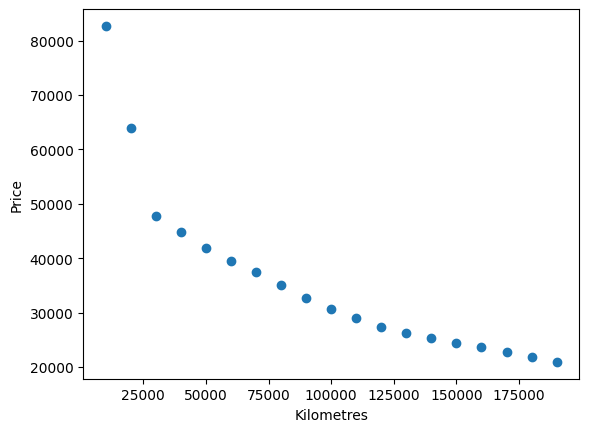

In [ ]:
elantra_km = [x for x in range(10000, 200000, 10000)]
elantra_prices = [predict_price(2016, 'ford', 'f-150', km, model, scaler_y) for km in elantra_km]

print(elantra_km)
print(elantra_prices)

plt.scatter(elantra_km, elantra_prices)
plt.xlabel('Kilometres')
plt.ylabel('Price')
plt.show()

#no accidemt / accidemt free vs. (yes accident if not listed)
#body type and trim

In [ ]:
# For testing the function with importing the files

import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import joblib
from tensorflow.keras.models import load_model

In [ ]:
encoder = joblib.load('encoder.pkl')
scaler_x = joblib.load('scaler_x.pkl')
scaler_y = joblib.load('scaler_y.pkl')
prediction_model = load_model('car_price_prediction_model.keras')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
loaded_columns = pd.read_csv('input_layer_columns.csv', header=None).squeeze('columns').tolist()

In [ ]:
categorical_cols = ['Make', 'Model']
numerical_cols = ['Kilometres', 'Year']

def oneHotEncodeCategoricalCols(df, categorical_cols, oneHotEncoder):
    try:
        encoded_data = oneHotEncoder.transform(df[categorical_cols])
        encoded_df = pd.DataFrame(encoded_data, columns=oneHotEncoder.get_feature_names_out(categorical_cols), index=df.index)
        df.drop(columns=categorical_cols, inplace=True)
        return pd.concat([df, encoded_df], axis=1)
    except Exception as e:
        print(f"Encoding error: {e}")
        exit()

In [ ]:
def scaleNumericalCols(df, numerical_cols, scaler):
    try:
        numerical_data = df[numerical_cols]
        other_data = df.drop(columns=numerical_cols)
        numerical_scaled = pd.DataFrame(scaler.transform(numerical_data), columns=numerical_cols, index=df.index)
        return pd.concat([numerical_scaled, other_data], axis=1)
    except Exception as e:
        print(f"Scaling error: {e}")
        exit()


In [ ]:
def predict_price(year, car_make, car_model, kilometres):
    try:
        input_data = pd.DataFrame({'Year': [year], 'Make': [car_make], 'Model': [car_model], 'Kilometres': [kilometres]})
        encoded_df = oneHotEncodeCategoricalCols(input_data, categorical_cols, encoder)
        scaled_df = scaleNumericalCols(encoded_df, numerical_cols, scaler_x)

        for col in [col for col in loaded_columns if col not in scaled_df.columns]:
            scaled_df[col] = 0

        prediction = prediction_model.predict(scaled_df.to_numpy())
        prediction_original = scaler_y.inverse_transform(prediction)
        return round(prediction_original[0][0], 2)
    except Exception as e:
        print(f"Prediction error: {e}")
        exit()


In [ ]:
print(predict_price(2018, 'volkswagen', 'golf gti', 40000))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
28070.54


In [ ]:
from flask import Flask, request, jsonify
import pandas as pd
import joblib
import tensorflow as tf

app = Flask(__name__)

# Column types
categorical_cols = ['Make', 'Model']
numerical_cols = ['Kilometres', 'Year']

# Encoders
oneHotEncoder = joblib.load('encoder.pkl')

# Scalers
scaler_x = joblib.load('scaler_x.pkl')
scaler_y = joblib.load('scaler_y.pkl')

# Model
model = tf.keras.models.load_model('car_price_prediction_model.keras')

# Required input layer columns for NN
loaded_columns = pd.read_csv('input_layer_columns.csv', header=None).squeeze('columns').tolist()

data = {
    'year': 2020,
    'make': 'honda',
    'model': 'civic',
    'km': 100000
}

def predict():
    year = data['year']
    car_make = data['make']
    car_model = data['model']
    km = data['km']

    input_df = pd.DataFrame({'Year': [year], 'Make': [car_make], 'Model': [car_model], 'Kilometres': [km]})

    # One hot encode categorical columns
    encoded_data = oneHotEncoder.transform(input_df[categorical_cols])
    encoded_df = pd.DataFrame(encoded_data, columns=oneHotEncoder.get_feature_names_out(categorical_cols), index=input_df.index)
    input_df.drop(columns=categorical_cols, inplace=True)
    encoded_df = pd.concat([input_df, encoded_df], axis=1)

    # Scale numerical columns
    numerical_data = encoded_df[numerical_cols]
    other_data = encoded_df.drop(columns=numerical_cols)
    numerical_scaled = pd.DataFrame(scaler_x.transform(numerical_data), columns=numerical_cols, index=encoded_df.index)
    scaled_df = pd.concat([numerical_scaled, other_data], axis=1)

    # Add columns to match input layer of NN
    for col in [col for col in loaded_columns if col not in scaled_df.columns]:
        scaled_df[col] = 0

    prediction = model.predict(scaled_df.to_numpy())
    prediction_original = scaler_y.inverse_transform(prediction)
    return round(prediction_original[0][0], 2)

print(predict())


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
26099.21


In [ ]:
import tensorflow as tf

# Load the existing Keras model
model = tf.keras.models.load_model('car_price_prediction_model.keras')

# Convert to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the .tflite model
with open('car_price_prediction_model.tflite', 'wb') as f:
    f.write(tflite_model)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Saved artifact at '/tmp/tmp4hzkhuq1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 747), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138951464452512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138951464457440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138951464464304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138951463584512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138951464467120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138951478103904: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
!pip install tflite-runtime
!pip show tflite-runtime

Name: tflite-runtime
Version: 2.14.0
Summary: TensorFlow Lite is for mobile and embedded devices.
Home-page: https://www.tensorflow.org/lite/
Author: Google, LLC
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy
Required-by: 


In [ ]:
from flask import Flask, request, jsonify
import pandas as pd
import joblib
import numpy as np
import tflite_runtime.interpreter as tflite

# Column types
categorical_cols = ['Make', 'Model']
numerical_cols = ['Kilometres', 'Year']

# Encoders
oneHotEncoder = joblib.load('encoder.pkl')

# Scalers
scaler_x = joblib.load('scaler_x.pkl')
scaler_y = joblib.load('scaler_y.pkl')

# TensorFlow Lite Model
interpreter = tflite.Interpreter(model_path='car_price_prediction_model.tflite')
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Required input layer columns for NN
loaded_columns = pd.read_csv('input_layer_columns.csv', header=None).squeeze('columns').tolist()

data = {
    'year': 2019,
    'make': 'ford',
    'model': 'focus',
    'km': 10000
}

def predict():
    year = data['year']
    car_make = data['make']
    car_model = data['model']
    km = data['km']

    input_df = pd.DataFrame({'Year': [year], 'Make': [car_make], 'Model': [car_model], 'Kilometres': [km]})

    # One hot encode categorical columns
    encoded_data = oneHotEncoder.transform(input_df[categorical_cols])
    encoded_df = pd.DataFrame(encoded_data, columns=oneHotEncoder.get_feature_names_out(categorical_cols), index=input_df.index)
    input_df.drop(columns=categorical_cols, inplace=True)
    encoded_df = pd.concat([input_df, encoded_df], axis=1)

    # Scale numerical columns
    numerical_data = encoded_df[numerical_cols]
    other_data = encoded_df.drop(columns=numerical_cols)
    numerical_scaled = pd.DataFrame(scaler_x.transform(numerical_data), columns=numerical_cols, index=encoded_df.index)
    scaled_df = pd.concat([numerical_scaled, other_data], axis=1)

    # Add columns to match input layer of NN
    for col in [col for col in loaded_columns if col not in scaled_df.columns]:
        scaled_df[col] = 0

    # Ensure input shape matches the TFLite model
    input_data = scaled_df.to_numpy().astype(np.float32)

    # Set input tensor
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Run inference
    interpreter.invoke()

    # Get the output
    prediction = interpreter.get_tensor(output_details[0]['index'])

    # Rescale the output to the original scale
    prediction_original = scaler_y.inverse_transform(prediction)
    prediction_rounded = round(prediction_original[0][0], 2)
    return prediction_rounded



print(predict())


58296.24


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
'''
Given preprocessed data:
- Identify max km of each model (with its given year)
- Export into JSON format
'''

df = pd.read_csv('cars_preprocessed.csv')

# Group by 'make', 'model', and 'year' and keep the row with the max 'km'
filtered_df = df.loc[df.groupby(['Make', 'Model', 'Year'])['Kilometres'].idxmax()]

# Convert the filtered DataFrame to a JSON format
car_json = filtered_df[['Make', 'Model', 'Year', 'Kilometres']].to_dict(orient='records')

# Save to a file
with open('cars.json', 'w') as f:
    json.dump(car_json, f, indent=4)

,Unnamed: 0,Price,Year,Make,Model,Kilometres
0,0,39399,2023,dodge,charger,13937
1,1,7494,2013,toyota,corolla,300622
2,2,45785,2020,bmw,x5,74851
3,3,94100,2024,dodge,durango,0
4,4,88140,2024,ford,mustang,33
...,...,...,...,...,...,...
58942,89671,18991,2020,nissan,qashqai,92021
58943,89672,20888,2021,buick,encore,89149
58944,89674,29888,2020,toyota,prius prime,72974
58945,89676,32448,2024,ford,escape,3407
